# Homework on Mining Massive Databases (MMDS)

**by Andrii Shevtsov and Markiian Mandzak**

Task formulation:
![Task formulation screenshot](./task.jpg)

## System specifications

All the experiments in this notebook run are run on a Windows OS VirtualBox virtual machine with:
- Ubuntu 20.04 OS;
- 8 (logical) cores of Ryzen 7 laptop version CPU dedicated;
- 24 GB of RAM dedicated;
- 20 GB of local hard drive dedicated.

## Imports and constants

In [1]:
import requests
import time
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
import re

from tqdm import tqdm
from pyspark.sql import SparkSession, functions as F, types as T, Window
from pyspark.ml.feature import HashingTF, IDF, Tokenizer, BucketedRandomProjectionLSH, Word2Vec
from pyspark.ml.linalg import Vector
from nltk.stem import PorterStemmer
from nltk.corpus import stopwords
from typing import Optional
from scipy.spatial import distance

from tree_stem import stem_word

We set spark session here as it is a singletone for our application:

In [ ]:
SPARK = SparkSession.builder \
    .appName("MMDS_HW_LSH") \
    .config("spark.executor.memory", "4g") \
    .config("spark.driver.memory", "8g") \
    .config("spark.driver.cores", "4") \
    .config("spark.executor.cores", "2") \
    .config('spark.sql.pivotMaxValues', u'30000') \
    .getOrCreate()

SPARK.sparkContext.setLogLevel("ERROR")

24/11/10 18:47:31 WARN Utils: Your hostname, ucuvm resolves to a loopback address: 127.0.1.1; using 10.0.2.15 instead (on interface enp0s3)
24/11/10 18:47:31 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/11/10 18:47:32 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


We will also download stopwords. Ukrainian stopwords are downloaded from [Ukrainian Stopwords GitHub repository by skupriienko](https://github.com/skupriienko/Ukrainian-Stopwords). We will mix them with english stopwords from the NLTK library:

In [ ]:
with open("stopwords_ua.txt") as f:
    stop_words_uk = f.readlines()
stop_words_uk = [word.replace('\n', '') for word in stop_words_uk]
try:
    STOP_WORDS = set(stopwords.words('english')).union(set(stop_words_uk))
except LookupError:
    nltk.download('stopwords')
    STOP_WORDS = set(stopwords.words('english')).union(set(stop_words_uk))

Other constants, that can be useful and are more like general settings:

In [3]:
SEARCHED_ELEMENTS_COUNT = 5  # Count of elements that should occur in search with LSH
BEST_PARAMS_COUNT = 3  # Count of best param sets to return during the grid search by default
ENCODING_METHOD = 'word2vec' # Method of encoding used for the feature vector (word2vec or tfidf)
VECTOR_SIZE = 64 # Size of the feature vector used

## Part 0. Common functions

Here, we list functions that are reutilized in both parts. This section is crucial in explaining our approach. Also it makes sure we use the same general approach for both tasks.

### Features calculation

In [4]:
@F.udf(T.ArrayType(T.StringType()))
def stem_and_clean(tokens, stemmer: Optional[str] = 'uk'):
    """A small UDF function to clean tokenized words from empty an then stem them"""
    cleaned_words = [token for token in tokens if token.strip() != "" and token not in STOP_WORDS]
    if stemmer == 'uk':
        return list(map(stem_word, cleaned_words))
    elif stemmer == 'nltk':
        stemmer = PorterStemmer()
        return list(map(stemmer.stem, cleaned_words))
    elif stemmer is None:
        return cleaned_words
    else:
        raise ValueError("For nowm only 'uk', 'nltk' and None stemmers are possible")


In [5]:
@F.udf(T.BooleanType())
def empty_words(words):
    return len(words) == 0

In [6]:
def add_features(df, input_text_col: str, output_features_col: str = 'features', stemmer: Optional[str] = 'uk', encoding_method: str = ENCODING_METHOD):
    """This function helps us to add vectors with features to the original dataframe with text
    
    Args:
        - df: pyspark DataFrame - a dataframe with `input_text_col` present, for which we should add a column with vectors of features
        - input_text_col: str - a name of column in `df` where we should take a text to obtain vector features
        - output_features_col: str - a name of a column in `df` where we should put final vectors with features
        - stemmer: Optional str - a name for a stemmer to be used during word stemming
        - encoding_method: str - a name for a method that is used for tokens vector encoding

    Returns:
        pyspark DataFrame, with `output_features_col` column added and filled with feature vectors
    """

    # We need to remove symbols to correctly tokenize the text
    df = df.withColumn(f'{input_text_col}_clean', F.regexp_replace(input_text_col, r'[^a-zA-Z\u0400-\u04FF]', ' '))

    tokenizer = Tokenizer(inputCol=f'{input_text_col}_clean', outputCol="words")
    df = tokenizer.transform(df)

    df = df.withColumn("stemmedWords", stem_and_clean(F.col("words"), F.lit(stemmer)))

    df = df.filter(~empty_words(F.col("stemmedWords")))

    if encoding_method == 'tfidf':
        hashingTF = HashingTF(inputCol="stemmedWords", outputCol="rawFeatures", numFeatures=VECTOR_SIZE)
        df = hashingTF.transform(df)
        idf = IDF(inputCol="rawFeatures", outputCol=output_features_col)
        idfModel = idf.fit(df)
        df = idfModel.transform(df)
    
    elif encoding_method == 'word2vec':
        word2Vec = Word2Vec(inputCol="stemmedWords", outputCol=output_features_col, vectorSize=VECTOR_SIZE, minCount=0)
        model = word2Vec.fit(df)
        df = model.transform(df)
    
    else:
        raise ValueError("Invalid ENCODING_METHOD. Choose 'tfidf' or 'word2vec'.")
    
    return df

### Ground truth similarity calculation

We should use some function to understand the distance (or similarity) between two feature vectors (for ground truth calculation). Cosine similarity is perfect for that:

In [7]:
@F.udf(T.DoubleType())
def cos_dist(vec_a, vec_b):
    if isinstance(vec_a, Vector) and isinstance(vec_b, Vector):
        dot_product = float(vec_a.dot(vec_b))
        norm_a = float(vec_a.norm(2))
        norm_b = float(vec_b.norm(2))
        return 1 - dot_product / (norm_a * norm_b) if norm_a and norm_b else 0.0
    return 2.0

@F.udf(T.DoubleType())
def euclidian_dist(vec_a, vec_b):
    return float(distance.euclidean(vec_a, vec_b))


Then, we need to have a function to calculate ground truth similarity and then obtaining ids of the closest elements:

In [8]:
def add_gt_similar(df, id_col: str, 
                   features_col: str = 'features', 
                   gt_similar_col: str = 'gt_similar', 
                   searched_elements_count: int = SEARCHED_ELEMENTS_COUNT,
                   distance: str = 'euclidian'):
    """Add column with lists of ids of similar ground truth elements
    
    Args:
        - df: pyspark DataFrame - a dataframe with `id_col` and `features_col` present, for which we should add a column with lists of similar items
        - id_col: str - a name of column in `df` where we should take indexes to put into `gt_similar_col`
        - features_col: str (default 'features') - a name of column in `df` where vector features are located
        - gt_similar_col: str (default 'gt_similar') - a name for a new column that is created as a result
        - searched_elements_count: int (default SEARCHED_ELEMENTS_COUNT) - maximum count of elements we want to search
        - distance: str (default 'euclidian') - what distance to use during computations
    
    Returns:
    pyspark DataFrame, a copy of `df` with filled `gt_similar_col` that contains ids of ground truth similar items
    """

    assert distance in ['euclidian', 'cosine'], "Distance should be either euclidian or cosine"
    dist_func = euclidian_dist if distance == 'euclidian' else cos_dist

    # We can now make an `NxN` similarity table, containing cosine similarities between each pair of feature vectors
    similarity_table = (
        df.alias('a')
        .crossJoin(df.alias('b'))
        .withColumn(
            'distance',
            dist_func(
                F.col(f'a.{features_col}'),
                F.col(f'b.{features_col}'),
            )
        )
        .groupBy(f'a.{id_col}')
        .pivot(f'b.{id_col}')
        .sum('distance')
        .orderBy(id_col)
    )

    # Now, we can obtain all the perspective similarity pairs (with similarity bigger than 0)
    similarity_columns = [column for column in similarity_table.columns if column != id_col]

    mapping_expr = []
    for c in similarity_columns:
        mapping_expr.extend([F.lit(c), F.col(c)])

    paired_df = similarity_table.select(
        F.col(id_col),
        F.explode(F.create_map(*mapping_expr)).alias("similar_id", "distance")
    ).filter(
        (F.col(id_col) != F.col("similar_id")) & (F.col("distance") > 0)
    )

    # And take top k similar items by the similarity value for each other item
    window_spec = Window.partitionBy(id_col).orderBy(F.col("distance").asc())
    paired_df = paired_df.withColumn("simrank", F.row_number().over(window_spec)).filter(F.col("simrank") <= searched_elements_count)

    # Here we collect lists with similar ids and add them to the original dataframe 
    top_similarities_df = paired_df.groupBy(id_col).agg(F.collect_list("similar_id").alias(gt_similar_col))
    res_df = df.join(top_similarities_df, on=id_col, how='left').orderBy(id_col)

    return res_df

### Predicting with LSH

In [9]:
def predict_similar_lsh(df, lsh_params, id_col: str, features_col: str = 'features', pred_similar_col: str = 'pred_similar', searched_elements_count: int = SEARCHED_ELEMENTS_COUNT):
    """Predict similar items with MinHashLSH and add them to the original dataframe into the `pred_similar_col` column
    
    Args:
        - df: pyspark DataFrame - a dataframe with `id_col` and `features_col` present, for which we should add a column with lists of similar items
        - id_col: str - a name of column in `df` where we should take indexes to put into `pred_similar_col`
        - features_col: str (default 'features') - a name of column in `df` where vector features are located
        - pred_similar_col: str (default 'pred_similar') - a name for a new column that is created as a result
        - searched_elements_count: int (default SEARCHED_ELEMENTS_COUNT) - maximum count of elements we want to search
    
    Returns:
    pyspark DataFrame, a copy of `df` with filled `pred_similar_col` column that contains ids of predicted similar items
    """
    
    num_hash_tables = lsh_params['numHashTables']
    distance_threshold = lsh_params['distanceThreshold']
    bucket_length = lsh_params['bucketLength']

    mh = BucketedRandomProjectionLSH(inputCol=features_col, outputCol="hashes", numHashTables=num_hash_tables, bucketLength=bucket_length)

    model = mh.fit(df)

    similar_items = model.approxSimilarityJoin(df, df, threshold=distance_threshold, distCol="distance")
    similar_items = similar_items.filter(F.col(f"datasetA.{id_col}") != F.col(f"datasetB.{id_col}"))
    similar_items = similar_items.orderBy(F.col("distance").asc())

    window_spec = Window.partitionBy(f"datasetA.{id_col}").orderBy(F.col("distance").asc())
    similar_items = similar_items.withColumn("simrank", F.row_number().over(window_spec)).filter(F.col("simrank") <= searched_elements_count)

    found_items = similar_items.groupBy(f"datasetA.{id_col}").agg(F.collect_list(f"datasetB.{id_col}").alias(pred_similar_col))

    res_df = df.join(found_items, on=id_col, how='left')

    return res_df

### Measuring quality

Let's also define a function to calculate the quality of our prediction. We will use intersection over union (IOU) to evaluate quality, as it is intuitive and penalizes both false positives and false negatives equally:

In [10]:
@F.udf(T.DoubleType())
def iou_func(real_items, pred_items):
    if real_items is None:
        return 1.
    elif pred_items is None:
        return 0.
    else:
        real_items_set = set([int(i) for i in real_items])
        pred_items_set = set([int(i) for i in pred_items])
        intersection_len = len(real_items_set.intersection(pred_items_set))
        union_len = len(real_items_set.union(pred_items_set))
        # Division of integers here somehow breaks the logic when NULL is passed in
        return float(intersection_len)/float(union_len)  

Now we need a function that makes an evaluation of the current parameters set (using time and IOU) for the LSH prediction:

In [11]:
def test_lsh_params(df, params, id_col: str, features_col: str = 'features', gt_similar_col: str='gt_similar', pred_similar_col: str = 'pred_similar', searched_elements_count: int = SEARCHED_ELEMENTS_COUNT):
    """A function to measure performance of the LSH algorithm with given parameters
    
    Args:
        - df: pyspark DataFrame - a dataframe with `id_col` and `features_col` present, for which we should add a column with lists of similar items
        - id_col: str - a name of column in `df` where we should take indexes to put into `pred_similar_col`
        - features_col: str (default 'features') - a name of column in `df` where vector features are located
        - gt_similar_col: str (default 'gt_similar') - a name for a column that contains ground truth values of similarity
        - pred_similar_col: str (default 'pred_similar') - a name for a new column that is created as a result
        - searched_elements_count: int (default SEARCHED_ELEMENTS_COUNT) - maximum count of elements we want to search
    
    Returns:
    dict, a dictionary with lst parameters and results of model with that parameters
    """
    
    start_time = time.time()
    test_iou_df = predict_similar_lsh(df, params, 
                                      id_col=id_col, 
                                      features_col=features_col, 
                                      pred_similar_col=pred_similar_col,
                                      searched_elements_count=searched_elements_count)

    test_iou_df = test_iou_df.withColumn("iou", iou_func(F.col(gt_similar_col), F.col(pred_similar_col)))

    iou_value = test_iou_df.agg(F.avg("iou")).collect()[0][0]

    # Computation time should be calculated only after collect that makes Spark perform all the operations
    computation_time = time.time() - start_time

    return {
        'params': params,
        'iou': iou_value,
        'computation_time': computation_time,
    }

### Performing grid search

Here is a function to perform grid search:

In [12]:
def grid_search_tuning(data, 
                       param_grid, 
                       id_col: str, 
                       features_col: str = 'features',
                       gt_similar_col: str = 'gt_similar',
                       pred_similar_col: str = 'pred_similar', 
                       searched_elements_count: int = SEARCHED_ELEMENTS_COUNT,
                       top_parameter_sets: int = BEST_PARAMS_COUNT,
                       verbose: bool = False):
    """A function to calculate test MinHashLSH with different parameters and find `top_parameter_sets` best

    Args:
        - df: pyspark DataFrame - a dataframe with `id_col` and `features_col` present, for which we should add a column with lists of similar items
        - param_grid: list of dicts - a list with paramer sets we want to evaluate on
        - id_col: str - a name of column in `df` where we should take indexes to put into `pred_similar_col`
        - features_col: str (default 'features') - a name of column in `df` where vector features are located
        - gt_similar_col: str (default 'gt_similar') - a name for a column that contains ground truth values of similarity
        - pred_similar_col: str (default 'pred_similar') - a name for a new column that is created as a result
        - searched_elements_count: int (default SEARCHED_ELEMENTS_COUNT) - maximum count of elements we want to search
        - top_parameter_sets: int (default BEST_PARAMS_COUNT) - count of best parameter sets we want to return. If <= 0; return all parameter sets
        - verbose: bool (default False) - whether to print additional data
    
    Returns:
    list of dicts, a dictionary with lst parameters and results of model with that parameters
    """
    results = []
    for params in tqdm(param_grid):
        result = test_lsh_params(data, 
                                 params, 
                                 id_col=id_col, 
                                 features_col=features_col, 
                                 gt_similar_col=gt_similar_col,
                                 pred_similar_col=pred_similar_col, 
                                 searched_elements_count=searched_elements_count)
        if verbose:
            print(result)
        results.append(result)

    top_results = sorted(results, key=lambda x: x['iou'], reverse=True)
    if top_parameter_sets > 0:
        top_results = top_results[:top_parameter_sets]

    return top_results


### Visualizing results

In [13]:
def visualize_gridsearch_res(gridsearch_res):
    """Plot two heatmaps with gridsearch results"""
    gridsearch_res_df = pd.DataFrame(gridsearch_res)

    gridsearch_res_df['numHashTables'] = gridsearch_res_df['params'].apply(lambda x: x.get('numHashTables'))
    gridsearch_res_df['distanceThreshold'] = gridsearch_res_df['params'].apply(lambda x: x.get('distanceThreshold'))
    gridsearch_res_df['bucketLength'] = gridsearch_res_df['params'].apply(lambda x: x.get('bucketLength'))
    gridsearch_res_df = gridsearch_res_df.drop(columns=['params'])

    bucketLengthsCount = len(gridsearch_res_df['bucketLength'].unique())

    fig, axs = plt.subplots(bucketLengthsCount, 2, figsize=(12, 6*bucketLengthsCount), squeeze=False)

    fig.suptitle("Results for different parameters")

    for i, bucket_length in enumerate(gridsearch_res_df['bucketLength'].unique()):
        gridsearch_res_df_bucket = gridsearch_res_df.loc[gridsearch_res_df['bucketLength'] == bucket_length].copy()
        iou_pivot = gridsearch_res_df_bucket.pivot(index="numHashTables", columns="distanceThreshold", values="iou")
        time_pivot = gridsearch_res_df_bucket.pivot(index="numHashTables", columns="distanceThreshold", values="computation_time")

        axs[i][0].set_title(f"IOU values for bucketLength={bucket_length}")
        sns.heatmap(iou_pivot, ax=axs[i][0], cmap='rocket_r')

        axs[i][1].set_title(f"Computation time in seconds for bucketLength={bucket_length}")
        sns.heatmap(time_pivot, ax=axs[i][1], cmap='rocket')

    plt.tight_layout()
    plt.show()

## Part 1. Barcelona LSH experiment

### Data general preparation

Download data if needed:

In [14]:
# !wget -O listings.csv.gz https://data.insideairbnb.com/spain/catalonia/barcelona/2024-09-06/data/listings.csv.gz
# !gunzip -f listings.csv.gz

Read data (via special function, because we are going to reuse it):

In [16]:
def load_airbnb_listings(filepath: str, values_count: int = 1000):
    listings_df = SPARK.read.csv(
        filepath,
        header=True,
        inferSchema=True,
        multiLine=True,
        escape="\"",
        quote="\"",
        sep=",",
    )
    if values_count > 0:
        listings_df = listings_df.limit(values_count)
    listings_df = listings_df.select("id", "name")
    listings_df = listings_df.dropna()
    listings_df = listings_df.dropDuplicates(["name"])
    listings_df = listings_df.orderBy("id")
    listings_df = listings_df.withColumn("id", F.monotonically_increasing_id())
    return listings_df

### Tuning

Here we work with a 1k-sized dataset.

In [16]:
listings_df = load_airbnb_listings("listings.csv")
print(listings_df.count())
listings_df.show(truncate=False)

998
+---+-------------------------------------------------+
|id |name                                             |
+---+-------------------------------------------------+
|0  |Huge flat for 8 people close to Sagrada Familia  |
|1  |Forum CCIB DeLuxe, Spacious, Large Balcony, relax|
|2  |Sagrada Familia area - Còrsega 1                 |
|3  |Stylish Top Floor Apartment - Ramblas Plaza Real |
|4  |VIDRE HOME PLAZA REAL on LAS RAMBLAS             |
|5  |Exquisite studio in Barcelona Born               |
|6  |In front of the beach                            |
|7  |Soho Colonial Eclectic Apartment                 |
|8  |Modern Apartment - Sagrada Familia               |
|9  |Sagrada Familia area - Còrsega 2                 |
|10 |Stylish & cozy 3BR near Sagrada Familia          |
|11 |Spacious 2 bedroom flat special offer 40% OFF    |
|12 |Charming apartment with fantastic views!         |
|13 |Best deals for penthouse near Sagrada Familia!   |
|14 |Long term entire months more than 32 ni

In [17]:
listings_df = add_features(listings_df, "name", "features", stemmer='nltk')
listings_df.show(truncate=False)

+---+-------------------------------------------------+-------------------------------------------------+------------------------------------------------------------+----------------------------------------------------+-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

In [18]:
listings_df = add_gt_similar(listings_df, id_col='id', features_col='features', gt_similar_col='gt_similar_listings')
listings_df.show(truncate=True)

+---+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+
| id|                name|          name_clean|               words|        stemmedWords|            features| gt_similar_listings|
+---+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+
|  0|Huge flat for 8 p...|Huge flat for   p...|[huge, flat, for,...|[huge, flat, peop...|[0.00385319686999...|[160, 646, 777, 6...|
|  1|Forum CCIB DeLuxe...|Forum CCIB DeLuxe...|[forum, ccib, del...|[forum, ccib, del...|[9.07797474480633...|[988, 860, 42, 33...|
|  2|Sagrada Familia a...|Sagrada Familia a...|[sagrada, familia...|[sagrada, familia...|[0.00506330142961...|[754, 86, 850, 39...|
|  3|Stylish Top Floor...|Stylish Top Floor...|[stylish, top, fl...|[stylish, top, fl...|[0.00214693906725...|[94, 653, 59, 636...|
|  4|VIDRE HOME PLAZA ...|VIDRE HOME PLAZA ...|[vidre, home, pla...|[vidr, h

In [19]:
possibleHashTablesCount = [1, 3, 5]
possibleDistanceThresholds = [0.3, 0.5, 0.9]
possibleBucketLenghts = [0.5, 1, 3]

param_grid = []
for hashTablesCount in possibleHashTablesCount:
    for distanceThreshold in possibleDistanceThresholds:
        for bucketLength in possibleBucketLenghts:
            param_grid.append({'numHashTables': hashTablesCount, 'distanceThreshold': distanceThreshold, 'bucketLength': bucketLength})

In [20]:
airbnb_parameters_evaled = grid_search_tuning(listings_df, 
                                              param_grid, 
                                              id_col="id", 
                                              features_col = 'features', 
                                              gt_similar_col = 'gt_similar_listings',
                                              pred_similar_col = 'pred_similar_listings', 
                                              top_parameter_sets = -1,
                                              verbose=True)

  4%|▎         | 1/27 [01:47<46:26, 107.19s/it]                                 

{'params': {'numHashTables': 1, 'distanceThreshold': 0.3, 'bucketLength': 0.5}, 'iou': 0.8250747526799616, 'computation_time': 107.19013023376465}


  7%|▋         | 2/27 [03:03<37:10, 89.21s/it]                                  

{'params': {'numHashTables': 1, 'distanceThreshold': 0.3, 'bucketLength': 1}, 'iou': 0.8250747526799616, 'computation_time': 76.60729265213013}


 11%|█         | 3/27 [04:19<33:13, 83.06s/it]                                  

{'params': {'numHashTables': 1, 'distanceThreshold': 0.3, 'bucketLength': 3}, 'iou': 0.8250747526799616, 'computation_time': 75.74555110931396}


 15%|█▍        | 4/27 [05:39<31:18, 81.67s/it]                                  

{'params': {'numHashTables': 1, 'distanceThreshold': 0.5, 'bucketLength': 0.5}, 'iou': 0.8250747526799616, 'computation_time': 79.53543782234192}


 19%|█▊        | 5/27 [07:05<30:33, 83.35s/it]                                  

{'params': {'numHashTables': 1, 'distanceThreshold': 0.5, 'bucketLength': 1}, 'iou': 0.8250747526799616, 'computation_time': 86.32423448562622}


 22%|██▏       | 6/27 [08:05<26:25, 75.50s/it]                                  

{'params': {'numHashTables': 1, 'distanceThreshold': 0.5, 'bucketLength': 3}, 'iou': 0.8250747526799616, 'computation_time': 60.24422240257263}


 26%|██▌       | 7/27 [09:18<24:49, 74.46s/it]                                  

{'params': {'numHashTables': 1, 'distanceThreshold': 0.9, 'bucketLength': 0.5}, 'iou': 0.8250747526799616, 'computation_time': 72.32331228256226}


 30%|██▉       | 8/27 [10:20<22:24, 70.76s/it]                                  

{'params': {'numHashTables': 1, 'distanceThreshold': 0.9, 'bucketLength': 1}, 'iou': 0.8250747526799616, 'computation_time': 62.81199073791504}


 33%|███▎      | 9/27 [11:19<20:04, 66.93s/it]                                  

{'params': {'numHashTables': 1, 'distanceThreshold': 0.9, 'bucketLength': 3}, 'iou': 0.8250747526799616, 'computation_time': 58.49589014053345}


 37%|███▋      | 10/27 [12:28<19:09, 67.60s/it]                                 

{'params': {'numHashTables': 3, 'distanceThreshold': 0.3, 'bucketLength': 0.5}, 'iou': 0.9426670801921293, 'computation_time': 69.09479260444641}


 41%|████      | 11/27 [13:43<18:36, 69.76s/it]                                 

{'params': {'numHashTables': 3, 'distanceThreshold': 0.3, 'bucketLength': 1}, 'iou': 0.9426670801921293, 'computation_time': 74.64629411697388}


 44%|████▍     | 12/27 [14:53<17:28, 69.93s/it]                                 

{'params': {'numHashTables': 3, 'distanceThreshold': 0.3, 'bucketLength': 3}, 'iou': 0.9426670801921293, 'computation_time': 70.32629728317261}


 48%|████▊     | 13/27 [16:04<16:25, 70.42s/it]                                 

{'params': {'numHashTables': 3, 'distanceThreshold': 0.5, 'bucketLength': 0.5}, 'iou': 0.9426670801921293, 'computation_time': 71.5538375377655}


 52%|█████▏    | 14/27 [17:17<15:22, 70.98s/it]                                 

{'params': {'numHashTables': 3, 'distanceThreshold': 0.5, 'bucketLength': 1}, 'iou': 0.9426670801921293, 'computation_time': 72.26036381721497}


 56%|█████▌    | 15/27 [18:25<14:02, 70.17s/it]                                 

{'params': {'numHashTables': 3, 'distanceThreshold': 0.5, 'bucketLength': 3}, 'iou': 0.9426670801921293, 'computation_time': 68.29922103881836}


 59%|█████▉    | 16/27 [19:35<12:49, 69.96s/it]                                 

{'params': {'numHashTables': 3, 'distanceThreshold': 0.9, 'bucketLength': 0.5}, 'iou': 0.9426670801921293, 'computation_time': 69.45592308044434}


 63%|██████▎   | 17/27 [20:41<11:28, 68.83s/it]                                 

{'params': {'numHashTables': 3, 'distanceThreshold': 0.9, 'bucketLength': 1}, 'iou': 0.9426670801921293, 'computation_time': 66.19772481918335}


 67%|██████▋   | 18/27 [21:44<10:04, 67.17s/it]                                 

{'params': {'numHashTables': 3, 'distanceThreshold': 0.9, 'bucketLength': 3}, 'iou': 0.9426670801921293, 'computation_time': 63.31663537025452}


 70%|███████   | 19/27 [22:58<09:13, 69.14s/it]                                 

{'params': {'numHashTables': 5, 'distanceThreshold': 0.3, 'bucketLength': 0.5}, 'iou': 0.9453033050227428, 'computation_time': 73.7042486667633}


 74%|███████▍  | 20/27 [24:12<08:14, 70.62s/it]                                 

{'params': {'numHashTables': 5, 'distanceThreshold': 0.3, 'bucketLength': 1}, 'iou': 0.9453033050227428, 'computation_time': 74.07240223884583}


 78%|███████▊  | 21/27 [25:22<07:02, 70.38s/it]                                 

{'params': {'numHashTables': 5, 'distanceThreshold': 0.3, 'bucketLength': 3}, 'iou': 0.9453033050227428, 'computation_time': 69.83239769935608}


 81%|████████▏ | 22/27 [26:37<05:59, 71.85s/it]                                 

{'params': {'numHashTables': 5, 'distanceThreshold': 0.5, 'bucketLength': 0.5}, 'iou': 0.9453033050227428, 'computation_time': 75.27315258979797}


 85%|████████▌ | 23/27 [27:51<04:49, 72.50s/it]                                 

{'params': {'numHashTables': 5, 'distanceThreshold': 0.5, 'bucketLength': 1}, 'iou': 0.9453033050227428, 'computation_time': 74.00194048881531}


 89%|████████▉ | 24/27 [29:11<03:44, 74.83s/it]                                 

{'params': {'numHashTables': 5, 'distanceThreshold': 0.5, 'bucketLength': 3}, 'iou': 0.9453033050227428, 'computation_time': 80.25347948074341}


 93%|█████████▎| 25/27 [30:23<02:28, 74.06s/it]                                 

{'params': {'numHashTables': 5, 'distanceThreshold': 0.9, 'bucketLength': 0.5}, 'iou': 0.9453033050227428, 'computation_time': 72.26301670074463}


 96%|█████████▋| 26/27 [31:35<01:13, 73.29s/it]                                 

{'params': {'numHashTables': 5, 'distanceThreshold': 0.9, 'bucketLength': 1}, 'iou': 0.9453033050227428, 'computation_time': 71.48428726196289}


100%|██████████| 27/27 [32:48<00:00, 72.92s/it]                                 

{'params': {'numHashTables': 5, 'distanceThreshold': 0.9, 'bucketLength': 3}, 'iou': 0.9453033050227428, 'computation_time': 73.42688322067261}


In [33]:
gridsearch_res_df = pd.DataFrame(airbnb_parameters_evaled)

gridsearch_res_df['numHashTables'] = gridsearch_res_df['params'].apply(lambda x: x.get('numHashTables'))
gridsearch_res_df['distanceThreshold'] = gridsearch_res_df['params'].apply(lambda x: x.get('distanceThreshold'))
gridsearch_res_df['bucketLength'] = gridsearch_res_df['params'].apply(lambda x: x.get('bucketLength'))
# gridsearch_res_df = gridsearch_res_df.drop(columns=['params'])

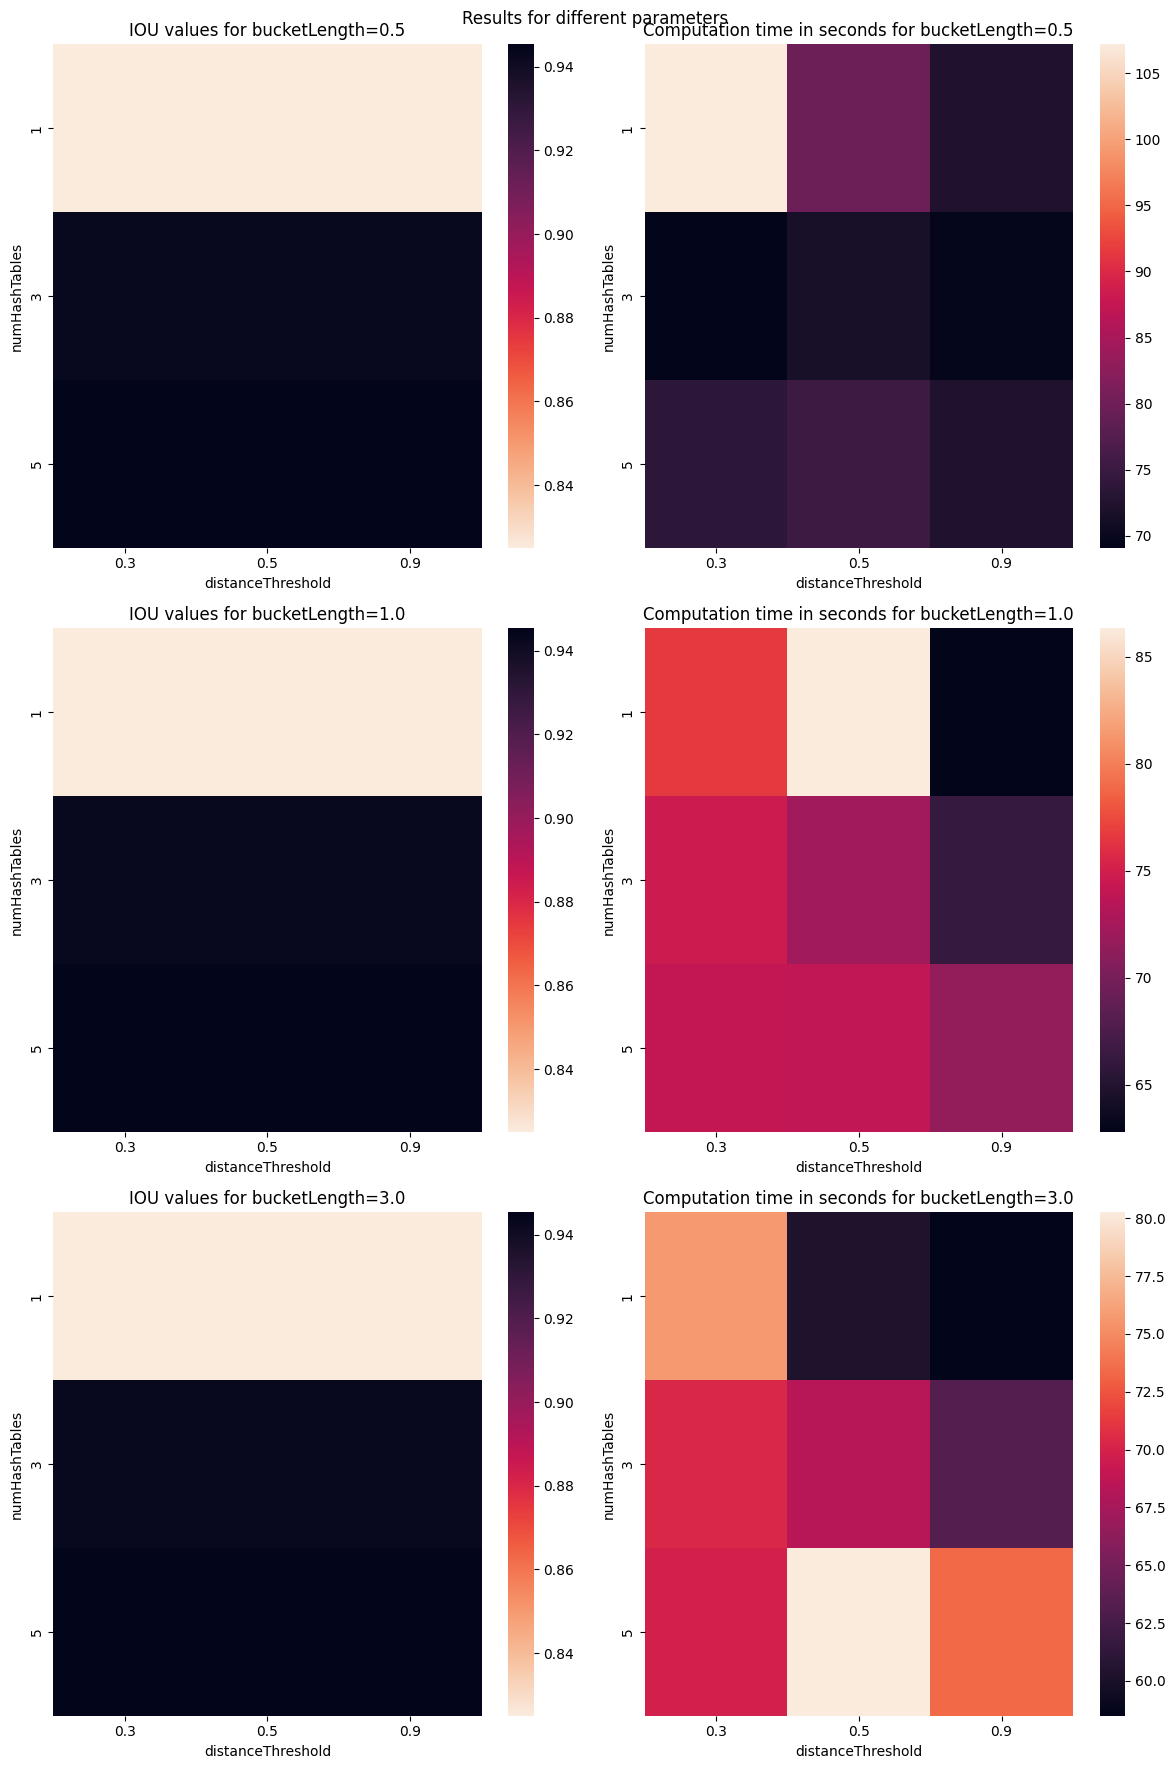

In [38]:
visualize_gridsearch_res(airbnb_parameters_evaled)

From the plots, we can make statements about parameters influence on IOU and computation time:
- `numHashTables`, hash tables count in LSH, is the only parameter that influences IOU, at least with those values of that parameters. More hash tables result in better accuracy (IOU), but it increases computation time in general.
- `distanceThreshold`, a threshold for aproximate NN join to cut by. In this range, it doesn't influence IOU but its increase leads to a bit faster computation. I would rather say that less threshold should lead to faster computations and decrease IOU, but maybe the filtering used by me afterwards to obtain K closest is almost equialent and mitigates this parameter.
- `bucketLength`, a length of the hash bucket. Its increase should increase IOU by lowering FNs, but we didn't encountered this case with this parameter range. Also, we can speculate that bigger bucket length results in faster calculations (range of calculation time is smaller 5 seconds each `bucketLength` increase).

In [39]:
airbnb_top_iou = max(airbnb_parameters_evaled, key=lambda x: x['iou'])['iou']
airbnb_top_iou_params = filter(lambda x: x['iou'] == airbnb_top_iou, airbnb_parameters_evaled)
airbnb_top_iou_and_smallest_time_params = min(airbnb_top_iou_params, key=lambda x: x['computation_time'])
print(f"""The best parameter set is {airbnb_top_iou_and_smallest_time_params['params']}.
It has IOU={airbnb_top_iou_and_smallest_time_params['iou']:.3f} and computation time of {airbnb_top_iou_and_smallest_time_params['computation_time']:.3f} seconds""")

The best parameter set is {'numHashTables': 5, 'distanceThreshold': 0.3, 'bucketLength': 3}.
It has IOU=0.945 and computation time of 69.832 seconds


### Full dataset results

Let's now calculate results for the (emulation of) full dataset. We can't run all 20k dataset on this machine, so we will try to process 5k and see if those parameters result in less accurate model for a bigger dataset. It should be a case, because there will be much more possible similar apartments in the dataset now.

In [17]:
listings_full_df = load_airbnb_listings("listings.csv", values_count=5_000)
listings_full_df = add_features(listings_full_df, "name", "features", stemmer='nltk')
listings_full_df.show()

+---+--------------------+--------------------+--------------------+--------------------+--------------------+
| id|                name|          name_clean|               words|        stemmedWords|            features|
+---+--------------------+--------------------+--------------------+--------------------+--------------------+
|  0|Huge flat for 8 p...|Huge flat for   p...|[huge, flat, for,...|[huge, flat, peop...|[-0.0311255447256...|
|  1|Forum CCIB DeLuxe...|Forum CCIB DeLuxe...|[forum, ccib, del...|[forum, ccib, del...|[0.00418941765591...|
|  2|Sagrada Familia a...|Sagrada Familia a...|[sagrada, familia...|[sagrada, familia...|[-0.0493932020850...|
|  3|Stylish Top Floor...|Stylish Top Floor...|[stylish, top, fl...|[stylish, top, fl...|[0.03702403950904...|
|  4|VIDRE HOME PLAZA ...|VIDRE HOME PLAZA ...|[vidre, home, pla...|[vidr, home, plaz...|[0.01855226924332...|
|  5|Exquisite studio ...|Exquisite studio ...|[exquisite, studi...|[exquisit, studio...|[0.01899541844613...|
|

As ground truth calculation involves pivot table computation, it has a time and space complexity of $N^2$, and therefore for 5k is ~25 times longer than for 1k sample. For the 10k, it took more than hour ($2^2$ longer than for 5k), and for the full dataset should be 4 times more longer. It is the main motivation we need LSH for big data, that usually has much more samples than 20k.

In [18]:
start_time = time.time()
listings_full_df = add_gt_similar(listings_full_df, id_col='id', features_col='features', gt_similar_col='gt_similar_listings')
listings_full_df.show()
print(f"Ground truth calculation took {time.time() - start_time:.3f} seconds")

+---+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+
| id|                name|          name_clean|               words|        stemmedWords|            features| gt_similar_listings|
+---+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+
|  0|Huge flat for 8 p...|Huge flat for   p...|[huge, flat, for,...|[huge, flat, peop...|[-0.0311255447256...|[998, 2044, 176, ...|
|  1|Forum CCIB DeLuxe...|Forum CCIB DeLuxe...|[forum, ccib, del...|[forum, ccib, del...|[0.00418941765591...|[2838, 3380, 2003...|
|  2|Sagrada Familia a...|Sagrada Familia a...|[sagrada, familia...|[sagrada, familia...|[-0.0493932020850...|[4660, 4785, 4673...|
|  3|Stylish Top Floor...|Stylish Top Floor...|[stylish, top, fl...|[stylish, top, fl...|[0.03702403950904...|[3348, 3534, 325,...|
|  4|VIDRE HOME PLAZA ...|VIDRE HOME PLAZA ...|[vidre, home, pla...|[vidr, h

In [19]:
airbnb_best_full_result = test_lsh_params(listings_full_df, 
                                        airbnb_top_iou_and_smallest_time_params['params'], 
                                        id_col='id', 
                                        features_col='features', 
                                        gt_similar_col='gt_similar_listings',
                                        pred_similar_col='pred_similar_listings')
print(f"LSH prediction calculation took {airbnb_best_full_result['computation_time']:.3f} seconds")
print(f"LSH prediction calculation resulted in {airbnb_best_full_result['iou']:.3f} mean IOU value")

LSH prediction calculation took 1113.339 seconds
LSH prediction calculation resulted in 0.931 mean IOU value


Here we see, that LSH computation is again longer, by 13% than GT computation. However, bigger hash tables count and even bigger dimensionality of the dataset are almost obliged to defeat this pattern. IOU for 5k is ~1% lower than for the 1K, meaning grid search tuning worked well on 1k dataset and the results of those in terms of quality are relevant for bigger dataset sizes.

## Part 2. Wikipedia LSH experiment

### Obtain data

In [40]:
wiki_request_res = requests.get("https://wikimedia.org/api/rest_v1/metrics/pageviews/top/uk.wikipedia.org/all-access/2024/09/all-days", headers={
    "Accept": "application/json",
    "User-Agent": "Mozilla/5.0 (X11; Ubuntu; Linux x86_64; rv:129.0) Gecko/20100101 Firefox/129.0",
    "Referer": "https://doc.wikimedia.org/"
})

In [41]:
articles_data = wiki_request_res.json()['items'][0]['articles']

### Transform data

In [42]:
articles_df = SPARK.createDataFrame(articles_data)

In [43]:
print(articles_df.count())
articles_df.show(truncate=False)

1000
+-----------------------------------------------+----+------+
|article                                        |rank|views |
+-----------------------------------------------+----+------+
|Головна_сторінка                               |1   |469652|
|Спеціальна:Пошук                               |2   |197066|
|Волинська_трагедія                             |3   |82508 |
|Klavdia_Petrivna                               |4   |79497 |
|Україна                                        |5   |61993 |
|YouTube                                        |6   |60683 |
|Сибіга_Андрій_Іванович                         |7   |58442 |
|Перша_світова_війна                            |8   |50199 |
|Національна_суспільна_телерадіокомпанія_України|9   |42675 |
|Масляков_Олександр_Васильович                  |10  |37677 |
|Нечуй-Левицький_Іван_Семенович                 |11  |37089 |
|Президентські_вибори_у_США_2024                |12  |35302 |
|Лавров_Сергій_Вікторович                       |13  |34938 |
|Бі

Let's add vectors of features to the dataframe:

In [44]:
articles_df = add_features(articles_df, "article", "features")

In [45]:
articles_df.show()

+--------------------+----+------+--------------------+--------------------+--------------------+--------------------+
|             article|rank| views|       article_clean|               words|        stemmedWords|            features|
+--------------------+----+------+--------------------+--------------------+--------------------+--------------------+
|    Головна_сторінка|   1|469652|    Головна сторінка| [головна, сторінка]|    [головн, сторін]|[0.00709146587178...|
|    Спеціальна:Пошук|   2|197066|    Спеціальна Пошук| [спеціальна, пошук]|  [спеціальн, пошук]|[-0.0061867532785...|
|  Волинська_трагедія|   3| 82508|  Волинська трагедія|[волинська, траге...| [волинськ, трагеді]|[-0.0022386910277...|
|    Klavdia_Petrivna|   4| 79497|    Klavdia Petrivna| [klavdia, petrivna]| [klavdia, petrivna]|[-0.0015689667779...|
|             Україна|   5| 61993|             Україна|           [україна]|            [україн]|[0.17835070192813...|
|             YouTube|   6| 60683|             Y

### Obtaining Ground Truth similarities

In [46]:
articles_df = add_gt_similar(articles_df, id_col='rank', features_col='features', gt_similar_col='gt_similar_articles')

Let's see newly added ground truth similar articles:

In [47]:
articles_df.show()

+----+--------------------+------+--------------------+--------------------+--------------------+--------------------+--------------------+
|rank|             article| views|       article_clean|               words|        stemmedWords|            features| gt_similar_articles|
+----+--------------------+------+--------------------+--------------------+--------------------+--------------------+--------------------+
|   1|    Головна_сторінка|469652|    Головна сторінка| [головна, сторінка]|    [головн, сторін]|[0.00709146587178...|[715, 240, 78, 32...|
|   2|    Спеціальна:Пошук|197066|    Спеціальна Пошук| [спеціальна, пошук]|  [спеціальн, пошук]|[-0.0061867532785...|[77, 406, 138, 38...|
|   3|  Волинська_трагедія| 82508|  Волинська трагедія|[волинська, траге...| [волинськ, трагеді]|[-0.0022386910277...|[138, 732, 88, 80...|
|   4|    Klavdia_Petrivna| 79497|    Klavdia Petrivna| [klavdia, petrivna]| [klavdia, petrivna]|[-0.0015689667779...|[432, 138, 469, 2...|
|   5|             У

## Prediction with Locality Sensitive Hashing

Let's create  a parameters grid:

In [48]:
possibleHashTablesCount = [1, 3, 5]
possibleDistanceThresholds = [0.3, 0.5, 0.9]
possibleBucketLenghts = [0.5, 1, 3]

param_grid = []
for hashTablesCount in possibleHashTablesCount:
    for distanceThreshold in possibleDistanceThresholds:
        for bucketLength in possibleBucketLenghts:
            param_grid.append({'numHashTables': hashTablesCount, 'distanceThreshold': distanceThreshold, 'bucketLength': bucketLength})

And perform the grid search. We want to obtain results for all the parameters to perform the visualization:

In [49]:
wiki_parameters_evaled = grid_search_tuning(articles_df, 
                                            param_grid, 
                                            id_col="rank",
                                            features_col = 'features', 
                                            gt_similar_col = 'gt_similar_articles',
                                            pred_similar_col = 'pred_similar_articles', 
                                            top_parameter_sets = -1,
                                            verbose=True)

  4%|▎         | 1/27 [00:58<25:16, 58.34s/it]                                  

{'params': {'numHashTables': 1, 'distanceThreshold': 0.3, 'bucketLength': 0.5}, 'iou': 0.42564957017289784, 'computation_time': 58.33662176132202}


  7%|▋         | 2/27 [01:43<21:11, 50.86s/it]                                  

{'params': {'numHashTables': 1, 'distanceThreshold': 0.3, 'bucketLength': 1}, 'iou': 0.42564957017289784, 'computation_time': 45.623950242996216}


 11%|█         | 3/27 [02:32<19:59, 49.97s/it]                                  

{'params': {'numHashTables': 1, 'distanceThreshold': 0.3, 'bucketLength': 3}, 'iou': 0.42564957017289784, 'computation_time': 48.90299081802368}


 15%|█▍        | 4/27 [03:19<18:39, 48.66s/it]                                  

{'params': {'numHashTables': 1, 'distanceThreshold': 0.5, 'bucketLength': 0.5}, 'iou': 0.42564957017289784, 'computation_time': 46.64592361450195}


 19%|█▊        | 5/27 [04:05<17:32, 47.84s/it]                                  

{'params': {'numHashTables': 1, 'distanceThreshold': 0.5, 'bucketLength': 1}, 'iou': 0.42564957017289784, 'computation_time': 46.399765729904175}


 22%|██▏       | 6/27 [04:52<16:38, 47.53s/it]                                  

{'params': {'numHashTables': 1, 'distanceThreshold': 0.5, 'bucketLength': 3}, 'iou': 0.42564957017289784, 'computation_time': 46.90801024436951}


 26%|██▌       | 7/27 [05:41<15:56, 47.82s/it]                                  

{'params': {'numHashTables': 1, 'distanceThreshold': 0.9, 'bucketLength': 0.5}, 'iou': 0.42564957017289784, 'computation_time': 48.42364001274109}


 30%|██▉       | 8/27 [06:28<15:07, 47.78s/it]                                  

{'params': {'numHashTables': 1, 'distanceThreshold': 0.9, 'bucketLength': 1}, 'iou': 0.42564957017289784, 'computation_time': 47.68003845214844}


 33%|███▎      | 9/27 [07:20<14:39, 48.85s/it]                                  

{'params': {'numHashTables': 1, 'distanceThreshold': 0.9, 'bucketLength': 3}, 'iou': 0.42564957017289784, 'computation_time': 51.20379590988159}


 37%|███▋      | 10/27 [08:16<14:27, 51.05s/it]                                 

{'params': {'numHashTables': 3, 'distanceThreshold': 0.3, 'bucketLength': 0.5}, 'iou': 0.7039867671206399, 'computation_time': 55.977208852767944}


 41%|████      | 11/27 [09:15<14:17, 53.56s/it]                                 

{'params': {'numHashTables': 3, 'distanceThreshold': 0.3, 'bucketLength': 1}, 'iou': 0.7039867671206399, 'computation_time': 59.265209436416626}


 44%|████▍     | 12/27 [10:18<14:05, 56.34s/it]                                 

{'params': {'numHashTables': 3, 'distanceThreshold': 0.3, 'bucketLength': 3}, 'iou': 0.7039867671206399, 'computation_time': 62.69868016242981}


 48%|████▊     | 13/27 [11:17<13:22, 57.31s/it]                                 

{'params': {'numHashTables': 3, 'distanceThreshold': 0.5, 'bucketLength': 0.5}, 'iou': 0.7039867671206399, 'computation_time': 59.54115152359009}


 52%|█████▏    | 14/27 [12:19<12:41, 58.61s/it]                                 

{'params': {'numHashTables': 3, 'distanceThreshold': 0.5, 'bucketLength': 1}, 'iou': 0.7039867671206399, 'computation_time': 61.588157415390015}


 56%|█████▌    | 15/27 [13:19<11:48, 59.04s/it]                                 

{'params': {'numHashTables': 3, 'distanceThreshold': 0.5, 'bucketLength': 3}, 'iou': 0.7039867671206399, 'computation_time': 60.04689335823059}


 59%|█████▉    | 16/27 [14:21<11:00, 60.05s/it]                                 

{'params': {'numHashTables': 3, 'distanceThreshold': 0.9, 'bucketLength': 0.5}, 'iou': 0.7039867671206399, 'computation_time': 62.38075232505798}


 63%|██████▎   | 17/27 [15:25<10:10, 61.05s/it]                                 

{'params': {'numHashTables': 3, 'distanceThreshold': 0.9, 'bucketLength': 1}, 'iou': 0.7039867671206399, 'computation_time': 63.3846218585968}


 67%|██████▋   | 18/27 [16:27<09:12, 61.34s/it]                                 

{'params': {'numHashTables': 3, 'distanceThreshold': 0.9, 'bucketLength': 3}, 'iou': 0.7039867671206399, 'computation_time': 62.01775240898132}


 70%|███████   | 19/27 [17:32<08:20, 62.54s/it]                                 

{'params': {'numHashTables': 5, 'distanceThreshold': 0.3, 'bucketLength': 0.5}, 'iou': 0.7374633761550574, 'computation_time': 65.334965467453}


 74%|███████▍  | 20/27 [18:32<07:12, 61.75s/it]                                 

{'params': {'numHashTables': 5, 'distanceThreshold': 0.3, 'bucketLength': 1}, 'iou': 0.7374633761550574, 'computation_time': 59.91901445388794}


 78%|███████▊  | 21/27 [19:36<06:15, 62.54s/it]                                 

{'params': {'numHashTables': 5, 'distanceThreshold': 0.3, 'bucketLength': 3}, 'iou': 0.7374633761550574, 'computation_time': 64.35049390792847}


 81%|████████▏ | 22/27 [21:09<05:58, 71.65s/it]                                 

{'params': {'numHashTables': 5, 'distanceThreshold': 0.5, 'bucketLength': 0.5}, 'iou': 0.7374633761550574, 'computation_time': 92.88927435874939}


 85%|████████▌ | 23/27 [22:43<05:13, 78.44s/it]                                 

{'params': {'numHashTables': 5, 'distanceThreshold': 0.5, 'bucketLength': 1}, 'iou': 0.7374633761550574, 'computation_time': 94.26707530021667}


 89%|████████▉ | 24/27 [23:48<03:42, 74.29s/it]                                 

{'params': {'numHashTables': 5, 'distanceThreshold': 0.5, 'bucketLength': 3}, 'iou': 0.7374633761550574, 'computation_time': 64.60778665542603}


 93%|█████████▎| 25/27 [24:48<02:20, 70.01s/it]                                 

{'params': {'numHashTables': 5, 'distanceThreshold': 0.9, 'bucketLength': 0.5}, 'iou': 0.7374633761550574, 'computation_time': 60.03626370429993}


 96%|█████████▋| 26/27 [25:49<01:07, 67.24s/it]                                 

{'params': {'numHashTables': 5, 'distanceThreshold': 0.9, 'bucketLength': 1}, 'iou': 0.7374633761550574, 'computation_time': 60.75818061828613}


100%|██████████| 27/27 [26:50<00:00, 59.66s/it]                                 

{'params': {'numHashTables': 5, 'distanceThreshold': 0.9, 'bucketLength': 3}, 'iou': 0.7374633761550574, 'computation_time': 61.5348904132843}


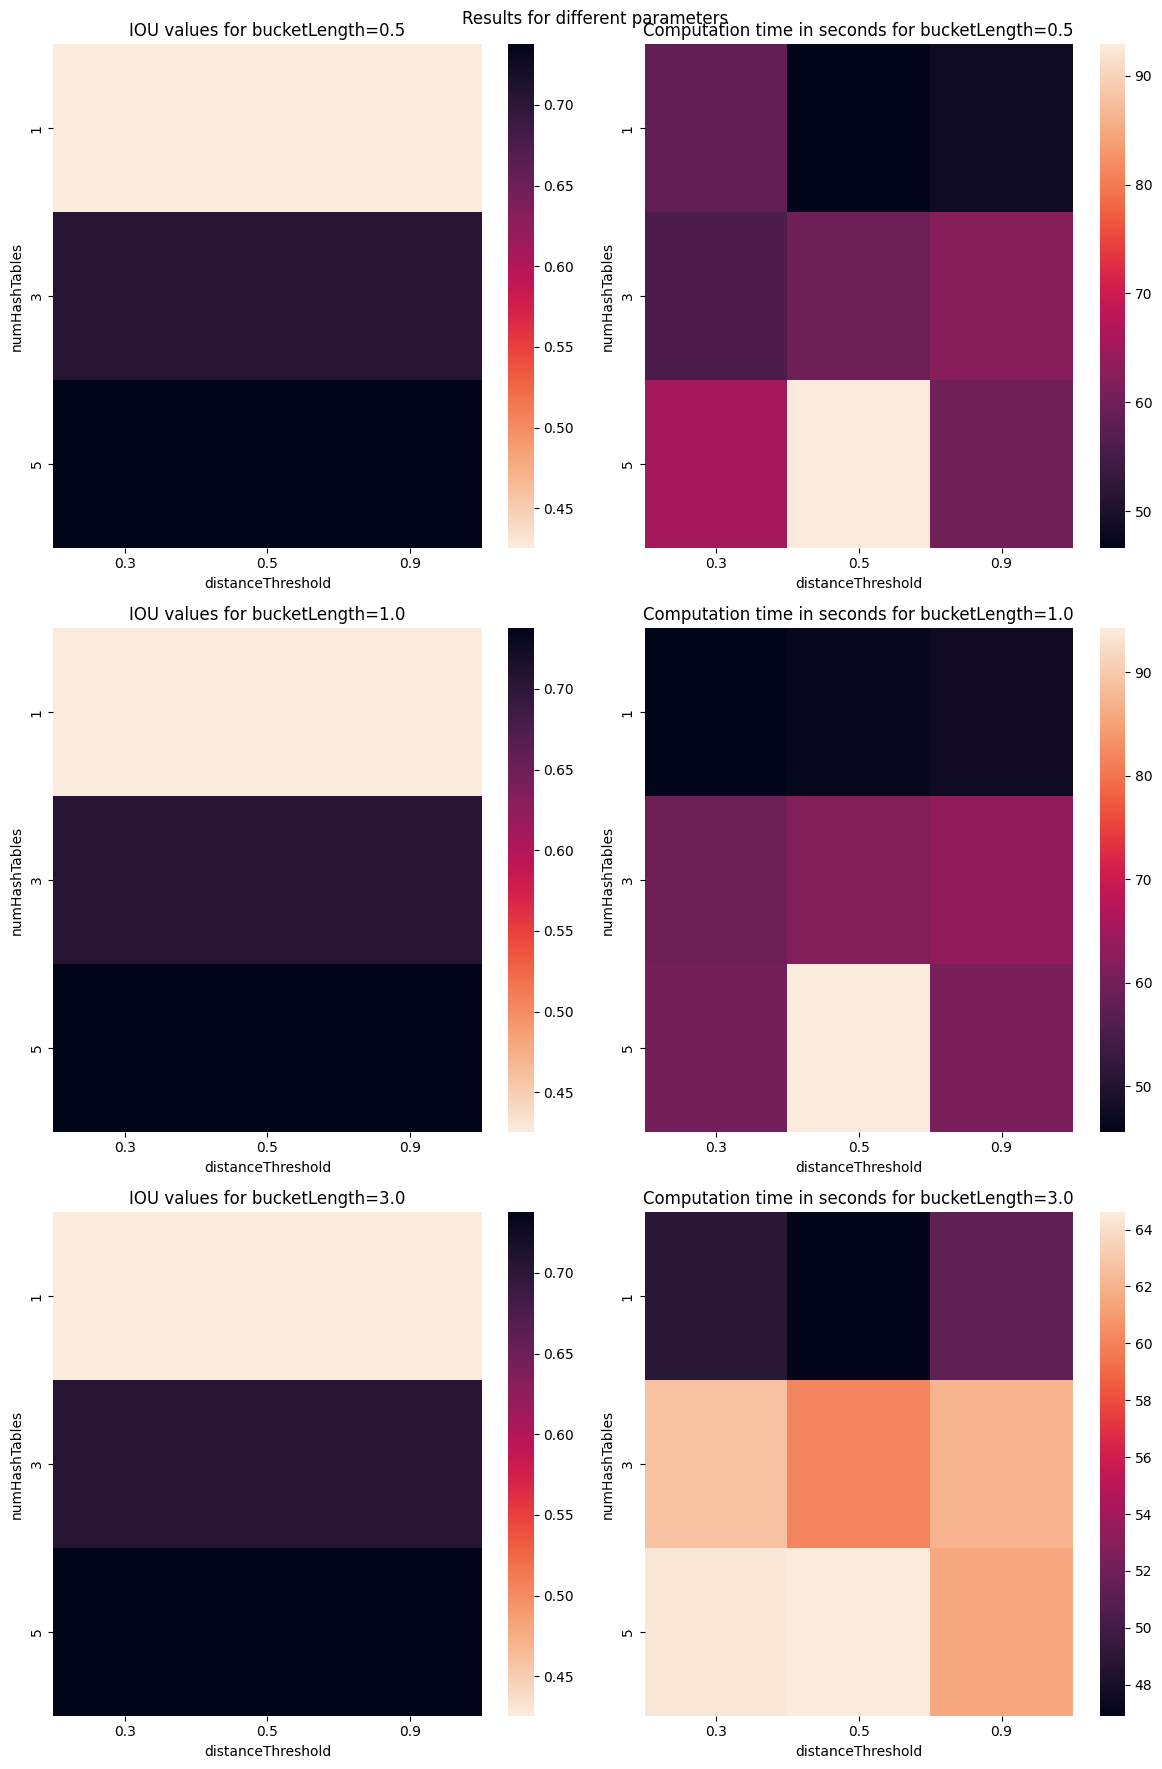

In [50]:
visualize_gridsearch_res(wiki_parameters_evaled)

In [51]:
wiki_top_iou = max(wiki_parameters_evaled, key=lambda x: x['iou'])['iou']
wiki_top_iou_params = filter(lambda x: x['iou'] == wiki_top_iou, wiki_parameters_evaled)
wiki_top_iou_and_smallest_time_params = min(wiki_top_iou_params, key=lambda x: x['computation_time'])
print(f"""The best parameter set is {wiki_top_iou_and_smallest_time_params['params']}.
It has IOU={wiki_top_iou_and_smallest_time_params['iou']:.3f} and computation time of {wiki_top_iou_and_smallest_time_params['computation_time']:.3f} seconds""")

The best parameter set is {'numHashTables': 5, 'distanceThreshold': 0.3, 'bucketLength': 1}.
It has IOU=0.737 and computation time of 59.919 seconds


Results for Ukrainian Wikipedia top-1000 articles is close to one obtained in Barcelona AirBnB LSH experiment. Once again, only hash tables count is influencing the accuracy, bigger bucket length results in faster computation and distance threshold influences almost nothing.

Still, here there is lower general quality of LSH solution, maybe due to less accurate stemming or bigger count of distinct words in article names compared to Barcelona flats and apartments.

## Part 3. Parameter substitution

Let's now run LSH experiment with the best AirBnB parameters on Wikipedia dataset:

In [52]:
airbnb_params_on_wiki_dataset_evaled = test_lsh_params(
    df=articles_df, 
    params=airbnb_top_iou_and_smallest_time_params['params'], 
    id_col="rank", 
    features_col = 'features', 
    gt_similar_col = 'gt_similar_articles',
    pred_similar_col = 'pred_similar_articles')
airbnb_params_on_wiki_dataset_evaled

{'params': {'numHashTables': 5, 'distanceThreshold': 0.3, 'bucketLength': 3},
 'iou': 0.7374633761550574,
 'computation_time': 56.067453145980835}

We see that the best hash tables count is equal for both datasets, leading to the same performance of those two parameter sets. The only difference here is computation time, that is even lower in this run, but it looks like a random decrease.

In our case, the best params are not very language (or dataset)-dependent, but the metrics on these datasets are.

## Final

We won't forget to stop spark... At least we will try :)

In [20]:
SPARK.stop()